In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import time

from numba import njit

import tensorflow as tf
import models
import methods

In [2]:
meta = models.Meta(num_tasks=4, dim=100, dtype=tf.float64, name="meta_0")
meta.restore()

2023-11-06 17:28:19.304507: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-06 17:28:19.304577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: apma-gpu-11
2023-11-06 17:28:19.304590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: apma-gpu-11
2023-11-06 17:28:19.304705: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2023-11-06 17:28:19.304750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.182.3
2023-11-06 17:28:19.304763: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.182.3


In [3]:
data = sio.loadmat("./data/example_3_train.mat")
x_test = data["x_test"]
y_test = data["y_test"]
f_test = data["f_test"]
u_test = data["u_test"]
x_train = data["x_train"]
y_train = data["y_train"]
f_train = data["f_train"]

In [4]:
basis = meta.basis(
    x_train, y_train
)
_basis, basis_xx, basis_yy = meta.pde2(x_train, y_train)
Phi = (basis_xx + basis_yy).numpy()
b = f_train.astype(np.float64)
Phi = Phi.astype(np.float64)
eps = 1

# least square
XTX = np.matmul(Phi.T, Phi)
bb = np.matmul(Phi.T, b)

c_ref = np.linalg.solve(XTX + eps * np.eye(100, dtype=np.float64), bb)

f_pred = meta.pde(x_train, y_train, tf.constant(c_ref, tf.float64)).numpy()
objective = np.sum((f_pred - f_train) ** 2) + eps * np.sum(c_ref ** 2)
L_ref = objective.copy()

In [5]:
basis = meta.basis(
    tf.constant(x_test.reshape([-1, 1]), tf.float64),
    tf.constant(y_test.reshape([-1, 1]), tf.float64),
)

u_pred = tf.matmul(basis, c_ref).numpy()
u_pred = u_pred.reshape([257, 257])

L2 = np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)
print(L2)

0.06524705473006423


#### Solving the problem with RK4 

This could be replaced by the method of least squares.

In [6]:
P0 = np.eye(100) / eps
q0 = np.zeros([Phi.shape[1], 1])
h = 0.001
Ps = [P0]
qs = [q0]
# update = njit(methods.update)
update = methods.update_RK4
t0 = time.time()

for i in range(x_train.shape[0]):
    # P, q = methods.update_RK4(Ps[-1], qs[-1], h, Phi[i:i+1, :], b[i:i+1, :], lamb=1)
    P, q = update(Ps[-1], qs[-1], h, Phi[i:i+1, :], b[i:i+1, :], lamb=1)
    Ps += [P]
    qs += [q]
    t1 = time.time()
    print(i, t1 - t0)
    t0 = time.time()

0 4.47748064994812
1 4.299833059310913
2 5.490551948547363
3 4.49864387512207
4 4.547391176223755
5 4.521570682525635
6 4.461025953292847
7 4.304104804992676
8 4.434678316116333
9 4.751508712768555
10 4.903913974761963
11 5.48538875579834
12 6.786831617355347
13 6.396679639816284
14 8.476160764694214
15 6.3316895961761475
16 5.917423963546753
17 4.648803472518921
18 3.959953546524048
19 4.190690994262695
20 4.059259414672852
21 4.488988876342773
22 4.334128141403198
23 4.05543327331543
24 4.143497705459595
25 4.024846792221069
26 4.151228427886963
27 4.117241859436035
28 4.0580034255981445
29 4.69564962387085
30 5.334011793136597
31 4.105241298675537
32 4.506026029586792
33 4.281184673309326
34 4.314762115478516
35 3.9682834148406982
36 4.08218789100647
37 4.4536638259887695
38 3.9086623191833496
39 4.078643083572388
40 4.28018045425415
41 3.9034435749053955
42 4.220653533935547
43 3.875859260559082
44 3.9824092388153076
45 3.901838541030884
46 4.103559494018555
47 3.9593522548675537
4

In [7]:
print(np.linalg.norm(q - c_ref, 1))
u_pred = tf.matmul(basis, q).numpy()
u_pred = u_pred.reshape([257, 257])
L2 = np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)
print(L2)

5.970298153426534e-10
0.06524705473412278


#### Changing $\alpha$ from $1$ to $0.1$

In [8]:
P_1, q_1 = Ps[-1].copy(), qs[-1].copy()

h = 0.01
lamb = 1 - 0.1
Ps_1, qs_1 = [P_1], [q_1]
for j in range(int(lamb//h)):
    for i in range(100):
        phi_i = np.zeros(shape=[1, 100])
        phi_i[0, i] = 1
        b_i = np.zeros(shape=[1, 1])
        P_1, q_1 = update(P_1, q_1, -h, phi_i, b_i, lamb=h)
    Ps_1 += [P_1]
    qs_1 += [q_1]

In [9]:
f1s_1 = []
f2s_1 = []
L2s_1 = []
alphas_1 = []
h = 0.01
for i, _q_1 in enumerate(qs_1):
    alphas_1 += [1 - i*h]
    f_pred = meta.pde(x_train, y_train, tf.constant(_q_1, tf.float64)).numpy()
    u_pred = tf.matmul(basis, _q_1).numpy().reshape([257, 257])
    f1s_1 += [0.5 * np.sum((f_pred - f_train) ** 2)]
    f2s_1 += [0.5 * np.sum(_q_1 ** 2)]
    L2s_1 += [np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)]

In [10]:
# check with reference
c_ref = np.linalg.solve(XTX + 0.1 * np.eye(100, dtype=np.float64), bb)
print(np.linalg.norm(q_1 - c_ref, 1))
u_pred = tf.matmul(basis, q_1).numpy()
u_pred = u_pred.reshape([257, 257])
L2 = np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)
print(L2)

1.517736310989535e-08
0.05679266097011841


#### Changing $\alpha$ from $0.1$ to $0.01$

In [11]:
P_2, q_2 = P_1.copy(), q_1.copy()

h = 0.001
lamb = 0.1 - 0.01
Ps_2, qs_2 = [P_2], [q_2]
for j in range(int(lamb//h)):
    for i in range(100):
        phi_i = np.zeros(shape=[1, 100])
        phi_i[0, i] = 1
        b_i = np.zeros(shape=[1, 1])
        P_2, q_2 = methods.update_RK4(P_2, q_2, -h, phi_i, b_i, lamb=h)
    Ps_2 += [P_2]
    qs_2 += [q_2]

In [12]:
f1s_2 = []
f2s_2 = []
L2s_2 = []
alphas_2 = []
h = 0.001
for i, _q_2 in enumerate(qs_2):
    alphas_2 += [0.1 - i*h]
    f_pred = meta.pde(x_train, y_train, tf.constant(_q_2, tf.float64)).numpy()
    u_pred = tf.matmul(basis, _q_2).numpy().reshape([257, 257])
    f1s_2 += [0.5 * np.sum((f_pred - f_train) ** 2)]
    f2s_2 += [0.5 * np.sum(_q_2 ** 2)]
    L2s_2 += [np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)]

In [13]:
# check with reference
c_ref = np.linalg.solve(XTX + 0.01 * np.eye(100, dtype=np.float64), bb)
print(np.linalg.norm(q_2 - c_ref, 1))
u_pred = tf.matmul(basis, q_2).numpy()
u_pred = u_pred.reshape([257, 257])
L2 = np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)
print(L2)

1.135710039788882e-06
0.030390077393291668


#### Changing $\alpha$ from $0.01$ to $0.001$

In [14]:
P_3, q_3 = P_2.copy(), q_2.copy()

h = 0.0001
lamb = 0.01 - 0.001
Ps_3, qs_3 = [P_3], [q_3]
for j in range(int(lamb//h)):
    for i in range(100):
        phi_i = np.zeros(shape=[1, 100])
        phi_i[0, i] = 1
        b_i = np.zeros(shape=[1, 1])
        P_3, q_3 = methods.update_RK4(P_3, q_3, -h, phi_i, b_i, lamb=h)
    Ps_3 += [P_3]
    qs_3 += [q_3]

In [15]:
f1s_3 = []
f2s_3 = []
L2s_3 = []
alphas_3 = []
h = 0.0001
for i, _q_3 in enumerate(qs_3):
    alphas_3 += [0.01 - i*h]
    f_pred = meta.pde(x_train, y_train, tf.constant(_q_3, tf.float64)).numpy()
    u_pred = tf.matmul(basis, _q_3).numpy().reshape([257, 257])
    f1s_3 += [0.5 * np.sum((f_pred - f_train) ** 2)]
    f2s_3 += [0.5 * np.sum(_q_3 ** 2)]
    L2s_3 += [np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)]

In [16]:
# check with reference
c_ref = np.linalg.solve(XTX + 0.001 * np.eye(100, dtype=np.float64), bb)
print(np.linalg.norm(q_3 - c_ref, 1))
u_pred = tf.matmul(basis, q_3).numpy()
u_pred = u_pred.reshape([257, 257])
L2 = np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)
print(L2)

2.1213837884823117e-05
0.01727971777237406


#### Changing $\alpha$ from $0.001$ to $0.0001$

In [17]:
P_4, q_4 = P_3.copy(), q_3.copy()

h = 0.000001
lamb = 0.001 - 0.0001
Ps_4, qs_4 = [P_4], [q_4]
for j in range(int(lamb//h)):
    for i in range(100):
        phi_i = np.zeros(shape=[1, 100])
        phi_i[0, i] = 1
        b_i = np.zeros(shape=[1, 1])
        P_4, q_4 = methods.update_RK4(P_4, q_4, -h, phi_i, b_i, lamb=h)
    Ps_4 += [P_4]
    qs_4 += [q_4]

In [18]:
f1s_4 = []
f2s_4 = []
L2s_4 = []
alphas_4 = []
h = 0.000001
for i, _q_4 in enumerate(qs_4):
    alphas_4 += [0.001 - i*h]
    f_pred = meta.pde(x_train, y_train, tf.constant(_q_4, tf.float64)).numpy()
    u_pred = tf.matmul(basis, _q_4).numpy().reshape([257, 257])
    f1s_4 += [0.5 * np.sum((f_pred - f_train) ** 2)]
    f2s_4 += [0.5 * np.sum(_q_4 ** 2)]
    L2s_4 += [np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)]

In [19]:
# check with reference
c_ref = np.linalg.solve(XTX + 0.0001 * np.eye(100, dtype=np.float64), bb)
print(np.linalg.norm(q_4 - c_ref, 1))
u_pred = tf.matmul(basis, q_4).numpy()
u_pred = u_pred.reshape([257, 257])
L2 = np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)
print(L2)

0.00025066584566234664
0.011661613650176513


#### Changing $\alpha$ from $0.0001$ to $0.00001$

In [20]:
P_5, q_5 = P_4.copy(), q_4.copy()

h = 0.0000001
lamb = 0.0001 - 0.00001
Ps_5, qs_5 = [P_5], [q_5]
for j in range(int(lamb//h)):
    for i in range(100):
        phi_i = np.zeros(shape=[1, 100])
        phi_i[0, i] = 1
        b_i = np.zeros(shape=[1, 1])
        P_5, q_5 = methods.update_RK4(P_5, q_5, -h, phi_i, b_i, lamb=h)
    Ps_5 += [P_5]
    qs_5 += [q_5]

In [21]:
f1s_5 = []
f2s_5 = []
L2s_5 = []
alphas_5 = []
h = 0.0000001
for i, _q_5 in enumerate(qs_5):
    alphas_5 += [0.0001 - i*h]
    f_pred = meta.pde(x_train, y_train, tf.constant(_q_5, tf.float64)).numpy()
    u_pred = tf.matmul(basis, _q_5).numpy().reshape([257, 257])
    f1s_5 += [0.5 * np.sum((f_pred - f_train) ** 2)]
    f2s_5 += [0.5 * np.sum(_q_5 ** 2)]
    L2s_5 += [np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)]

In [22]:
# check with reference
c_ref = np.linalg.solve(XTX + 0.00001 * np.eye(100, dtype=np.float64), bb)
print(np.linalg.norm(q_5 - c_ref, 1))
u_pred = tf.matmul(basis, q_5).numpy()
u_pred = u_pred.reshape([257, 257])
L2 = np.linalg.norm((u_pred-u_test).reshape([-1, 1]), 2) / np.linalg.norm(u_test.reshape([-1, 1]), 2)
print(L2)

0.006688448015439451
0.01473544862889329


#### Results

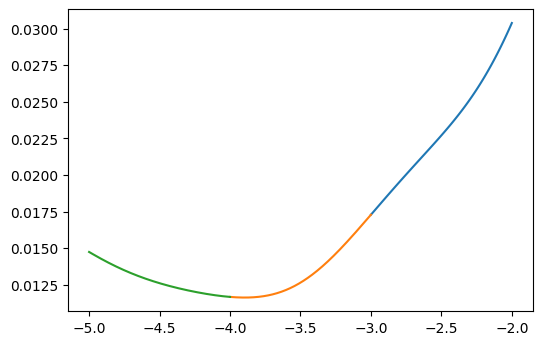

In [23]:
# Error versus regularization weight
plt.figure(dpi=100)
plt.plot(np.log10(alphas_3), L2s_3)
plt.plot(np.log10(alphas_4), L2s_4)
plt.plot(np.log10(alphas_5), L2s_5)
plt.show()

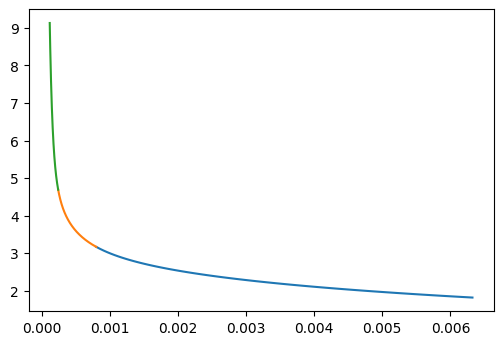

In [24]:
# Pareto front
plt.figure(dpi=100)
plt.plot(f1s_3, f2s_3)
plt.plot(f1s_4, f2s_4)
plt.plot(f1s_5, f2s_5)
plt.show()